# Precision-Recall Curve

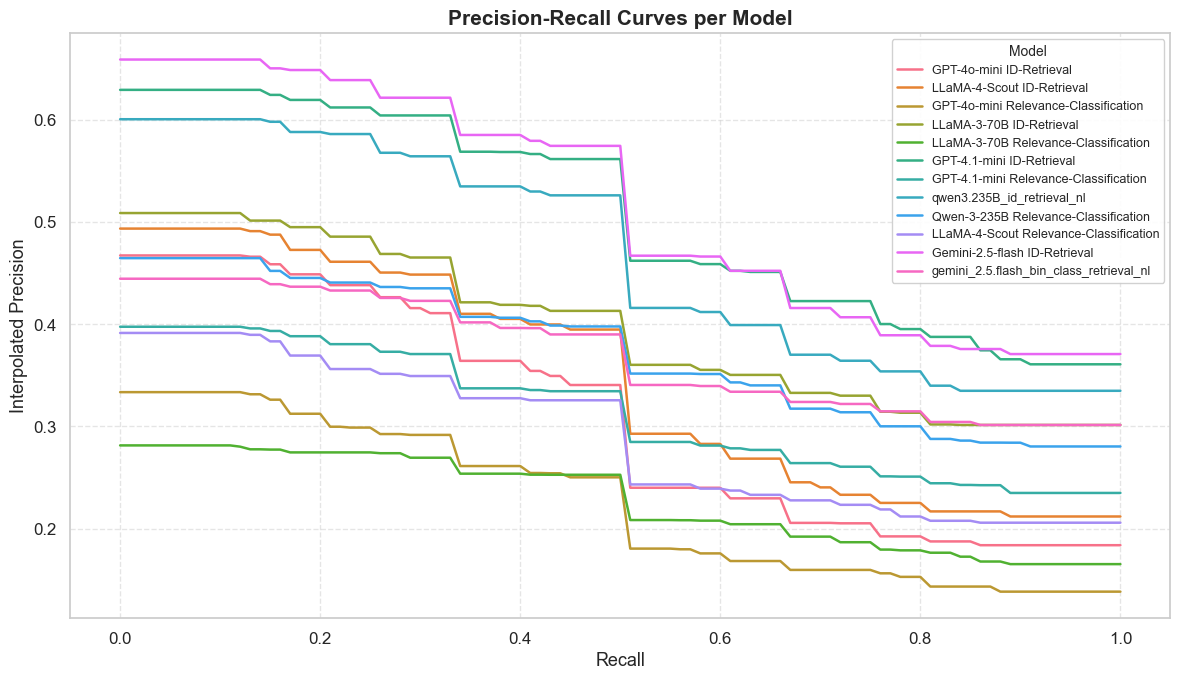

In [ ]:

import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import os

output_folder = "retrievals/analysis"
os.makedirs(output_folder, exist_ok=True)

with open("../sampling_hard_negatives/gold_standard_nl.json") as f:
    gold_data = json.load(f)

# === Human-readable model name mapping ===
def format_model_name(raw):
    name_map = {
        "gemini_2.5_flash": "Gemini-2.5-flash",
        "qwen3.235b": "Qwen-3-235B",
        "gpt4o.mini": "GPT-4o-mini",
        "gpt4.1.mini": "GPT-4.1-mini",
        "llama3.3.70b": "LLaMA-3-70B",
        "llama4.scout": "LLaMA-4-Scout",
    }

    for key in name_map:
        if key in raw:
            label = name_map[key]
            if "bin_class" in raw:
                return f"{label} Relevance-Classification"
            else:
                return f"{label} ID-Retrieval"
    return raw

# === Load retrievals ===
retrievals_folder = "retrievals/json"
model_files = [f for f in os.listdir(retrievals_folder) if f.endswith(".json")]
precision_recall_points = []

for filename in model_files:
    with open(os.path.join(retrievals_folder, filename)) as f:
        model_data = json.load(f)

    model_name_raw = filename.replace(".json", "").replace("evaluation_", "")
    model_name = format_model_name(model_name_raw)

    all_precisions = []
    all_recalls = []

    for query_id, gold_docs in gold_data.items():
        gold_set = set(gold_docs)
        retrieved_list = model_data.get(query_id, [])
        retrieved_set = set()

        precisions = []
        recalls = []

        for i, doc_id in enumerate(retrieved_list):
            retrieved_set.add(doc_id)
            tp = len(gold_set & retrieved_set)
            fp = len(retrieved_set - gold_set)
            fn = len(gold_set - retrieved_set)

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

            precisions.append(precision)
            recalls.append(recall)

        if recalls:
            all_precisions.append(precisions)
            all_recalls.append(recalls)

    recall_levels = np.linspace(0.0, 1.0, 101)
    interpolated_precisions = []

    for r in recall_levels:
        precision_at_r = []
        for prec_list, rec_list in zip(all_precisions, all_recalls):
            p = max([p for p, rec in zip(prec_list, rec_list) if rec >= r], default=0.0)
            precision_at_r.append(p)
        interpolated_precisions.append(np.mean(precision_at_r))

    for r, p in zip(recall_levels, interpolated_precisions):
        precision_recall_points.append({
            "Model": model_name,
            "Recall": r,
            "Precision": p
        })

# === Create DataFrame and plot ===
df_pr = pd.DataFrame(precision_recall_points)

# Seaborn styling
sns.set(style="whitegrid", context="notebook", font_scale=1.1)
palette = sns.color_palette("husl", n_colors=df_pr["Model"].nunique())

plt.figure(figsize=(12, 7))

sns.lineplot(
    data=df_pr,
    x="Recall",
    y="Precision",
    hue="Model",
    palette=palette,
    linewidth=1.8,
    legend="full"
)

# Labels and title
plt.title("Precision-Recall Curves per Model", fontsize=15, weight="bold")
plt.xlabel("Recall", fontsize=13)
plt.ylabel("Interpolated Precision", fontsize=13)

# Legend in top-right
plt.legend(
    title="Model",
    loc="upper right",
    fontsize=9,
    title_fontsize=10,
    frameon=True,
    framealpha=0.9
)

plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "precision_recall_curve.png"), dpi=300)
plt.show()

# Model Comparison (ID-Retrieval vs Relevance-Classification)

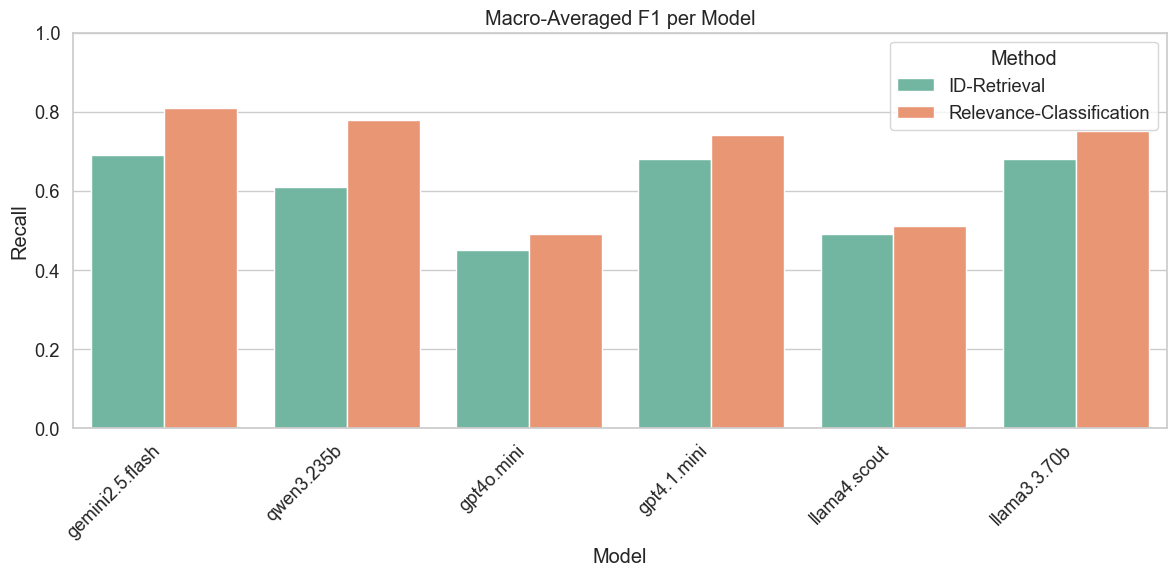

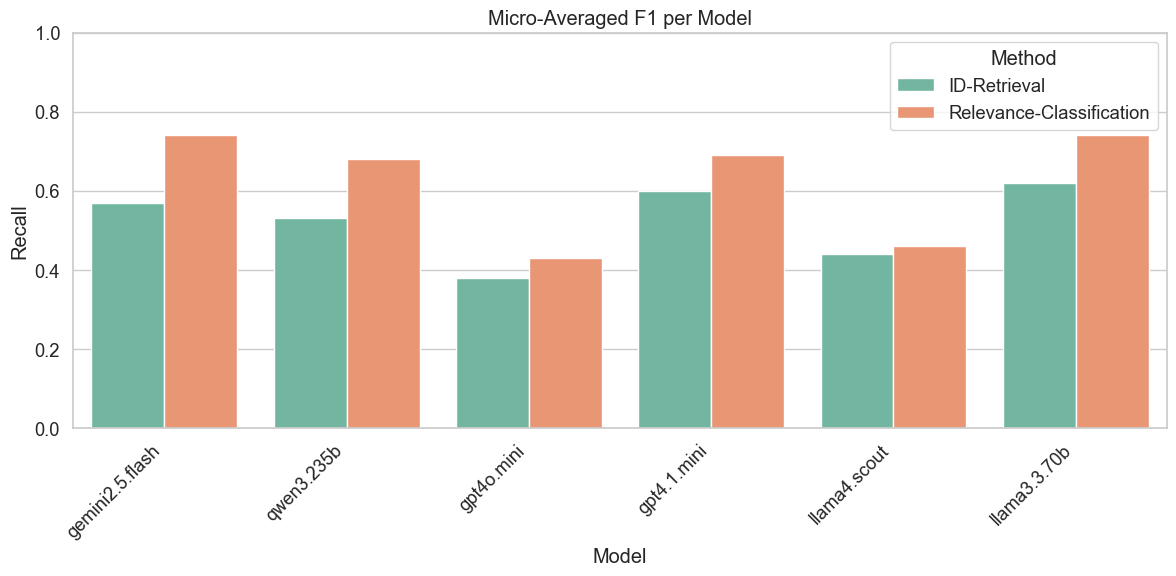

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

output_folder = "retrievals/analysis"
os.makedirs(output_folder, exist_ok=True)

# === Load data ===
macro_df = pd.read_csv("retrievals/evaluation/macro_scores.csv")
micro_df = pd.read_csv("retrievals/evaluation/micro_scores.csv")

# Melt
macro_long = macro_df.melt(id_vars=["Model","Method"],
                           value_vars=["Precision","Recall","F1-Score"],
                           var_name="Metric", value_name="Score")
micro_long = micro_df.melt(id_vars=["Model","Method"],
                           value_vars=["Precision","Recall","F1-Score"],
                           var_name="Metric", value_name="Score")

# Filter to F1 only
macro_f1 = macro_long[macro_long["Metric"] == "Recall"]
micro_f1 = micro_long[micro_long["Metric"] == "Recall"]

# Macro F1
plt.figure(figsize=(12,6))
sns.barplot(data=macro_f1, x="Model", y="Score", hue="Method", palette="Set2", errorbar=None, dodge=True)
plt.title("Macro-Averaged F1 per Model"); plt.ylim(0,1); plt.ylabel("Recall"); plt.xlabel("Model")
plt.xticks(rotation=45, ha="right"); plt.legend(title="Method", loc="upper right")
plt.tight_layout(); plt.savefig(os.path.join(output_folder,"macro_metrics_comparison_recall.png"), dpi=300); plt.show()

# Micro F1  **(use micro_f1!)**
plt.figure(figsize=(12,6))
sns.barplot(data=micro_f1, x="Model", y="Score", hue="Method", palette="Set2", errorbar=None, dodge=True)
plt.title("Micro-Averaged F1 per Model"); plt.ylim(0,1); plt.ylabel("Recall"); plt.xlabel("Model")
plt.xticks(rotation=45, ha="right"); plt.legend(title="Method", loc="upper right")
plt.tight_layout(); plt.savefig(os.path.join(output_folder,"micro_metrics_comparison_recall.png"), dpi=300); plt.show()

## Retrieval Statistics

In [ ]:
import json
from pathlib import Path
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

# -------- CONFIG --------
INPUT_DIR = Path("retrievals/json")  # folder with the 12 JSON output files
GOLD_PATH = Path("gold_data/gold_standard_nl.json")  # gold standard file

OUTPUT_DIR = Path("retrievals/analysis")
OUTPUT_AGG_CSV = OUTPUT_DIR / "retrieval_counts_agg.csv"
OUTPUT_DETAILED_CSV = OUTPUT_DIR / "retrieval_counts_detailed.csv"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# -------- HELPERS --------
def parse_model_and_scenario(stem: str):
    s = stem.lower()
    if "_id_retrieval_" in s:
        scenario = "ID-Retrieval"
    elif "_bin_class_retrieval_" in s:
        scenario = "Relevance-Classification"
    else:
        scenario = "Unknown"
    return stem, scenario  # keep raw stem; we'll prettify separately

def pretty_model_label(stem: str) -> str:
    s = stem.lower()
    # normalize separators
    s = s.replace("__", "_").replace("-", "_")

    if "qwen" in s:
        return "Qwen-3-235B"
    if "gemini" in s and ("2.5" in s or "2_5" in s) and "flash" in s:
        return "Gemini-2.5-flash"
    if ("gpt4o" in s or "gpt_4o" in s or "gpt-4o" in s) and ("mini" in s):
        return "GPT-4o-mini"
    if ("gpt4.1" in s or "gpt_4_1" in s or "gpt-4.1" in s) and ("mini" in s):
        return "GPT-4.1-mini"
    if "llama3" in s and ("70b" in s or "70_b" in s or "3.3" in s or "3_3" in s):
        return "LLaMA-3-70B"
    if ("llama4" in s or "llama_4" in s) and ("scout" in s):
        return "LLaMA-4-Scout"
    # fallback: keep original stem if no match
    return stem

def normalize_str(x):
    return str(x).strip()

# -------- LOAD GOLD --------
with open(GOLD_PATH, "r", encoding="utf-8") as f:
    gold = json.load(f)
gold_norm = {normalize_str(q): set(normalize_str(doc) for doc in docs) for q, docs in gold.items()}

# -------- FIND INPUT FILES --------
files = sorted([p for p in INPUT_DIR.glob("*.json")])
if not files:
    print(f"No JSON files found in {INPUT_DIR}")
    raise SystemExit

# -------- PROCESS EACH FILE --------
detailed_rows = []

for fp in files:
    stem = fp.stem
    raw_model, scenario = parse_model_and_scenario(stem)
    model_label = pretty_model_label(raw_model)

    with open(fp, "r", encoding="utf-8") as f:
        data = json.load(f)

    preds = {normalize_str(q): [normalize_str(x) for x in ids] for q, ids in data.items()}

    for qid in gold_norm.keys():
        ranks = preds.get(qid, [])
        gold_set = gold_norm[qid]

        retrieved_count = len(ranks)
        unique_ranks = list(dict.fromkeys(ranks))
        retrieved_unique_count = len(unique_ranks)

        tp_raw = sum(1 for rid in ranks if rid in gold_set)
        tp_unique = len(set(unique_ranks) & gold_set)

        detailed_rows.append({
            "model": model_label,           # <-- pretty name here
            "scenario": scenario,
            "query_id": qid,
            "retrieved_count": retrieved_count,
            "retrieved_unique_count": retrieved_unique_count,
            "gold_count": len(gold_set),
            "true_pos_count": tp_raw,
            "true_pos_unique_count": tp_unique,
            "file": fp.name,
        })

# -------- BUILD DATAFRAMES --------
df_detail = pd.DataFrame(detailed_rows)

agg = (
    df_detail
    .groupby(["model", "scenario"], as_index=False)
    .agg(
        queries=("query_id", "nunique"),
        avg_retrieved=("retrieved_count", "mean"),
        avg_retrieved_unique=("retrieved_unique_count", "mean"),
        avg_gold=("gold_count", "mean"),
        avg_true_pos=("true_pos_count", "mean"),
        avg_true_pos_unique=("true_pos_unique_count", "mean"),
    )
    .sort_values(["model", "scenario"])
)

# Save with 2 decimals in CSV
df_detail.to_csv(OUTPUT_DETAILED_CSV, index=False, float_format="%.2f")
agg.to_csv(OUTPUT_AGG_CSV, index=False, float_format="%.2f")

print(f"Saved detailed per-query counts to: {OUTPUT_DETAILED_CSV}")
print(f"Saved aggregated counts to:       {OUTPUT_AGG_CSV}")
print("\nPreview aggregate:")
print(agg.head(12).to_string(index=False))

# -------- PLOTS: Single grouped bar (retrieved vs true positives) --------
import matplotlib.pyplot as plt

models_order = sorted(agg["model"].unique().tolist())

# Build two small pivot tables for the two metrics we want to show
plot_df_retr = (
    agg.pivot(index="model", columns="scenario", values="avg_retrieved")
       .reindex(models_order)
       .fillna(0.0)
)
plot_df_tp = (
    agg.pivot(index="model", columns="scenario", values="avg_true_pos")
       .reindex(models_order)
       .fillna(0.0)
)

x = range(len(models_order))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

id_vals_retr = plot_df_retr.get("ID-Retrieval", pd.Series([0]*len(models_order), index=models_order)).values
rc_vals_retr = plot_df_retr.get("Relevance-Classification", pd.Series([0]*len(models_order), index=models_order)).values

# Offset for second pair of bars within each model group
offset = 0.18

# Retrieved bars
ax.bar([p - width/2 - offset/2 for p in x], id_vals_retr, width/2, label="Retrieved (ID)")
ax.bar([p - width/2 + offset/2 for p in x], rc_vals_retr, width/2, label="Retrieved (RC)")

# True positives bars
id_vals_tp = plot_df_tp.get("ID-Retrieval", pd.Series([0]*len(models_order), index=models_order)).values
rc_vals_tp = plot_df_tp.get("Relevance-Classification", pd.Series([0]*len(models_order), index=models_order)).values

ax.bar([p + width/2 - offset/2 for p in x], id_vals_tp, width/2, label="True Pos (ID)")
ax.bar([p + width/2 + offset/2 for p in x], rc_vals_tp, width/2, label="True Pos (RC)")

# Add horizontal line for avg gold relevant articles
avg_gold = agg["avg_gold"].mean()
ax.axhline(avg_gold, color="gray", linestyle="--", linewidth=1, alpha=0.7)
ax.text(len(models_order) - 0.5, avg_gold + 0.1, f"Avg. gold = {avg_gold:.2f}",
        color="gray", fontsize=9, ha="right", va="bottom")

ax.set_title("Avg. Retrieved vs True Positives per Model and Scenario")
ax.set_ylabel("Average count")
ax.set_xticks(list(x))
ax.set_xticklabels(models_order, rotation=45, ha="right")
ax.legend()
ax.grid(True, axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "retrieved_vs_truepos_grouped_bar.png", dpi=300)
plt.close()

print("Saved plot:", OUTPUT_DIR / "retrieved_vs_truepos_grouped_bar.png")

Saved detailed per-query counts to: retrievals/analysis/retrieval_counts_detailed.csv
Saved aggregated counts to:       retrievals/analysis/retrieval_counts_agg.csv

Preview aggregate:
           model                 scenario  queries  avg_retrieved  avg_retrieved_unique  avg_gold  avg_true_pos  avg_true_pos_unique
    GPT-4.1-mini             ID-Retrieval      203          10.67                  8.95      2.55          1.89                 1.53
    GPT-4.1-mini Relevance-Classification      203          13.43                 13.43      2.55          1.76                 1.76
     GPT-4o-mini             ID-Retrieval      203           4.80                  4.50      2.55          1.00                 0.98
     GPT-4o-mini Relevance-Classification      203           7.63                  7.63      2.55          1.09                 1.09
Gemini-2.5-flash             ID-Retrieval      203           7.60                  7.59      2.55          1.46                 1.46
Gemini-2.5-flash 

#  F1-score Barplots with Error Bars or Per-Query Variance

### Making json files with per-query metrics

In [11]:
import os
import json

# === Paths ===
gold_path = "../sampling_hard_negatives/gold_standard_nl.json"
retrievals_folder = "retrievals/json"
output_folder = "retrievals/analysis/per_query_scores"

# Create output folder
os.makedirs(output_folder, exist_ok=True)

# === Load gold standard ===
with open(gold_path) as f:
    gold_data = json.load(f)

# === Process each model ===
model_files = [f for f in os.listdir(retrievals_folder) if f.endswith(".json")]

for filename in model_files:
    with open(os.path.join(retrievals_folder, filename)) as f:
        model_data = json.load(f)

    per_query_scores = {}

    for query_id, gold_docs in gold_data.items():
        gold_set = set(gold_docs)
        pred_set = set(model_data.get(query_id, []))

        tp = len(gold_set & pred_set)
        fp = len(pred_set - gold_set)
        fn = len(gold_set - pred_set)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        per_query_scores[query_id] = {
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "precision": round(precision, 4),
            "recall": round(recall, 4),
            "f1": round(f1, 4)
        }

    # === Save per-query results ===
    model_name = filename.replace(".json", "").replace("evaluation_", "")
    output_path = os.path.join(output_folder, f"{model_name}.json")
    with open(output_path, "w") as out_f:
        json.dump(per_query_scores, out_f, indent=2)

print("Per-query evaluation files saved to:", output_folder)

Per-query evaluation files saved to: retrievals/analysis/per_query_scores


### Plot F1-Score with error bars

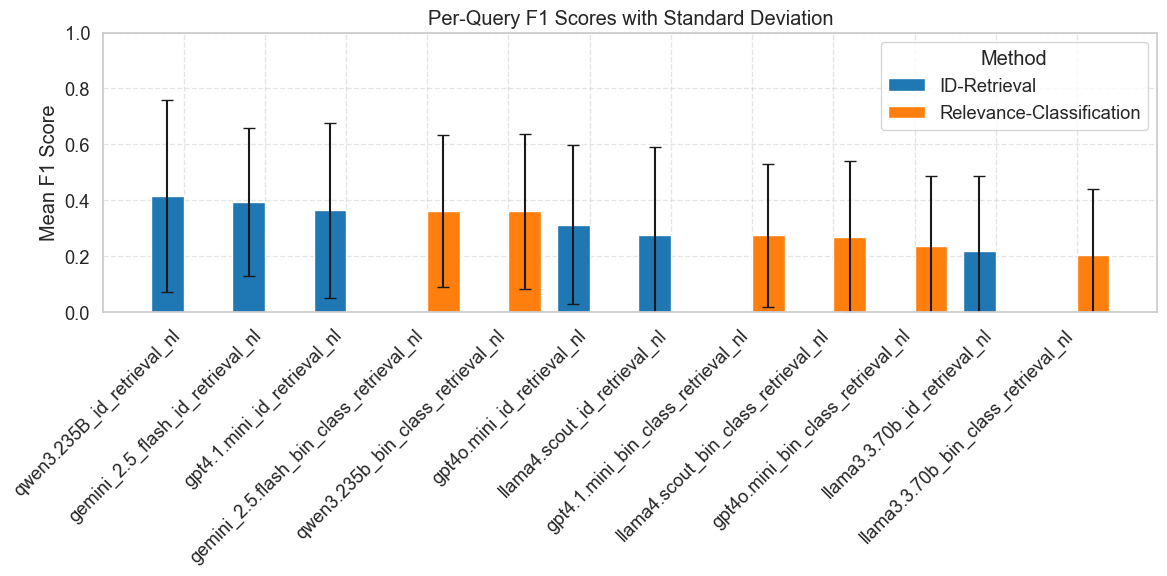

In [21]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Load per-query scores ===
per_query_folder = "retrievals/analysis/per_query_scores"
model_files = [f for f in os.listdir(per_query_folder) if f.endswith(".json")]

records = []

for filename in model_files:
    with open(os.path.join(per_query_folder, filename)) as f:
        data = json.load(f)

    model_name = filename.replace(".json", "")

    f1_scores = [v["f1"] for v in data.values()]
    mean_f1 = sum(f1_scores) / len(f1_scores)
    std_f1 = pd.Series(f1_scores).std()

    method = "Relevance-Classification" if "bin_class" in model_name else "ID-Retrieval"

    records.append({
        "Model": model_name,
        "Method": method,
        "MeanF1": mean_f1,
        "StdF1": std_f1
    })

df = pd.DataFrame(records)

# Sort for visual clarity
df = df.sort_values(by="MeanF1", ascending=False).reset_index(drop=True)

# === Separate by method ===
id_df = df[df["Method"] == "ID-Retrieval"].reset_index(drop=True)
cls_df = df[df["Method"] == "Relevance-Classification"].reset_index(drop=True)

n = len(df)
x = np.arange(n)  # total x positions
bar_width = 0.4

# === Align the bars ===
bar_positions = {name: i for i, name in enumerate(df["Model"])}

id_x = [bar_positions[m] - bar_width/2 for m in id_df["Model"]]
cls_x = [bar_positions[m] + bar_width/2 for m in cls_df["Model"]]

# === Plot ===
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(id_x, id_df["MeanF1"], width=bar_width, yerr=id_df["StdF1"], label="ID-Retrieval", capsize=4, color="#1f77b4")
ax.bar(cls_x, cls_df["MeanF1"], width=bar_width, yerr=cls_df["StdF1"], label="Relevance-Classification", capsize=4, color="#ff7f0e")

# Axis labels and formatting
ax.set_ylabel("Mean F1 Score")
ax.set_title("Per-Query F1 Scores with Standard Deviation")
ax.set_xticks(x)
ax.set_xticklabels(df["Model"], rotation=45, ha="right")
ax.set_ylim(0, 1)
ax.legend(title="Method", loc="upper right")
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
os.makedirs("retrievals/analysis", exist_ok=True)
plt.savefig("retrievals/analysis/per_query_f1_with_errorbars.png", dpi=300)
plt.show()

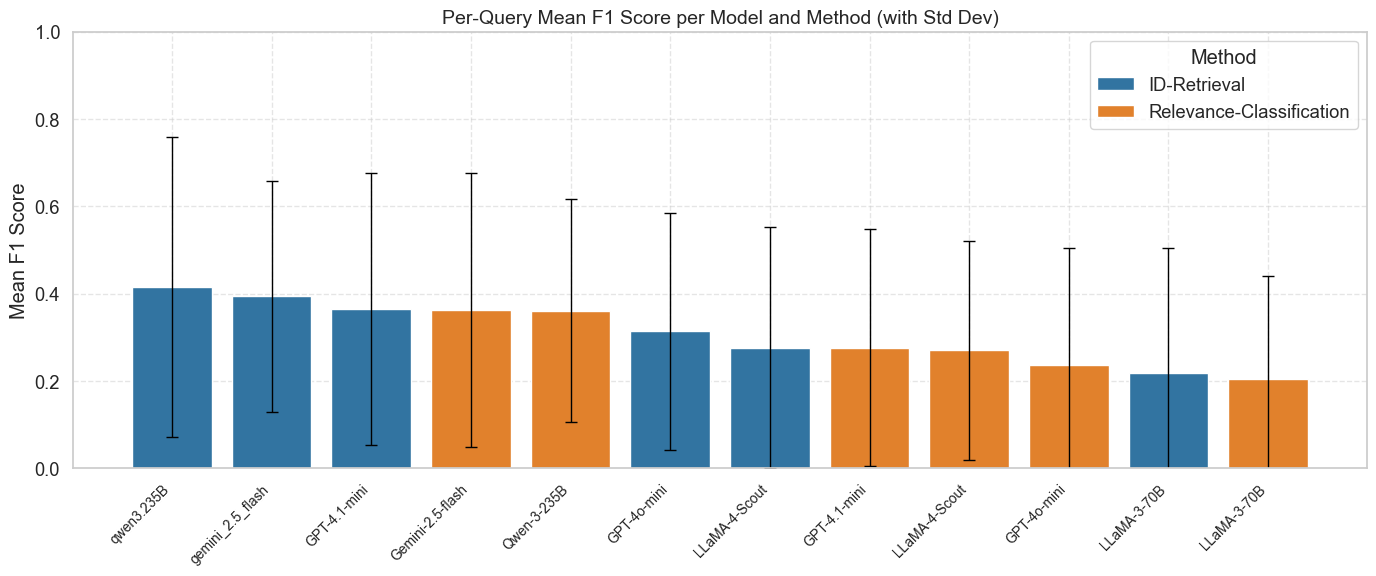

In [28]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Load per-query scores ===
per_query_folder = "retrievals/analysis/per_query_scores"
model_files = [f for f in os.listdir(per_query_folder) if f.endswith(".json")]

# === Mapping to clean model names ===
def pretty_name(model_id):
    model_id = model_id.replace("_id_retrieval_nl", "").replace("_bin_class_retrieval_nl", "")
    mapping = {
        "gemini_2.5.flash": "Gemini-2.5-flash",
        "qwen3.235b": "Qwen-3-235B",
        "gpt4o.mini": "GPT-4o-mini",
        "gpt4.1.mini": "GPT-4.1-mini",
        "llama3.3.70b": "LLaMA-3-70B",
        "llama4.scout": "LLaMA-4-Scout"
    }
    for key in mapping:
        if key in model_id:
            return mapping[key]
    return model_id

# === Build DataFrame ===
records = []
for filename in model_files:
    model_id = filename.replace(".json", "")
    with open(os.path.join(per_query_folder, filename)) as f:
        data = json.load(f)

    f1s = [v["f1"] for v in data.values()]
    method = "Relevance-Classification" if "bin_class" in model_id else "ID-Retrieval"
    model = pretty_name(model_id)

    records.append({
        "Model": model,
        "Method": method,
        "MeanF1": pd.Series(f1s).mean(),
        "StdF1": pd.Series(f1s).std()
    })

df = pd.DataFrame(records)
df = df.sort_values(by="MeanF1", ascending=False).reset_index(drop=True)

# Assign numeric x-position
df["Index"] = range(len(df))

# === Plot ===
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(14, 6))

palette = {"ID-Retrieval": "#1f77b4", "Relevance-Classification": "#ff7f0e"}

# Use numeric index for x
barplot = sns.barplot(
    data=df,
    x="Index",
    y="MeanF1",
    hue="Method",
    palette=palette,
    dodge=False,
    errorbar=None
)

# Add error bars
for bar, (_, row) in zip(barplot.patches, df.iterrows()):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.errorbar(x, y, yerr=row["StdF1"], fmt='none', c='black', capsize=4, linewidth=1)

# Manual x-tick labels = model names (even if repeated)
plt.xticks(ticks=df["Index"], labels=df["Model"], rotation=45, ha="right", fontsize=10)

# Styling
plt.title("Per-Query Mean F1 Score per Model and Method (with Std Dev)", fontsize=14)
plt.ylabel("Mean F1 Score")
plt.xlabel("")
plt.ylim(0, 1)
plt.legend(title="Method", loc="upper right")
plt.grid(True, linestyle="--", alpha=0.5)

# Save
plt.tight_layout()
os.makedirs("retrievals/analysis", exist_ok=True)
plt.savefig("retrievals/analysis/per_query_f1_labeled_legend.png", dpi=300)
plt.show()